<a href="https://colab.research.google.com/github/okana2ki/gai4e/blob/main/team_allocaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Embeddingを用いたチーム編成

## 準備

### 日本語で利用可能なtext embeddingモデルの例

以下は、日本語で利用可能なtext embeddingモデルの例です（出典：NLP204チュートリアル, 松田寛）

日本語のモデル：

[SimCSE](https://aclanthology.org/2021.emnlp-main.552/), Gao+ (2021/04)
をベースにしたもの

> [Japanese SimCSE (BERT-base)](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) (2022/12)

> [Japanese Simple-SimCSE](https://github.com/hppRC/simple-simcse-ja?tab=readme-ov-file), Tsukagoshi+ (2023/10)

[ColBERT](https://arxiv.org/abs/2004.12832), Khattab+ (2020/04)
をベースにしたもの

> [JaColBERT](https://huggingface.co/bclavie/JaColBERT), Clavié (2023/12)

多言語モデルの例：

> [multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large), Wang+ (2024/02)


### Japanese SimCSE (BERT-base) モデルのロード

 このノートブックでは、text embeddingモデルとして、[Japanese SimCSE (BERT-base) ](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) を使用します。

 sentence-transformersを使って、このモデルを簡単に利用することができます。トークナイズのために、fugashiとunidic-liteが必要です。まず、下記のように、pipでsentence-transformersとfugashi, unidic-liteをインストールします。

In [ ]:
!pip install -U fugashi[unidic-lite]
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('pkshatech/simcse-ja-bert-base-clcmlp')

### モデルを利用した埋め込み (embedding) 作成例

In [ ]:
sentences = [
    "PKSHA Technologyは機械学習/深層学習技術に関わるアルゴリズムソリューションを展開している。",
    "この深層学習モデルはPKSHA Technologyによって学習され、公開された。",
    "広目天は、仏教における四天王の一尊であり、サンスクリット語の「種々の眼をした者」を名前の由来とする。",
]

embeddings = model.encode(sentences)
print(embeddings)

### 類似度はcosine類似度がお勧め

Japanese SimCSE (BERT-base) モデルは、学習時の損失関数にcosine類似度を使っているため、下流のタスクで**cosine類似度を類似度計算に使うことをおすすめ**します。とのとです。

## アンケート情報の読み込みと埋め込みへの変換

In [ ]:
# prompt: グーグルドライブ上のCSVファイルを読み込む

from google.colab import drive
import pandas as pd

# Google Driveをマウント
drive.mount('/content/drive')

# CSVファイルのパスを指定
file_path = '/content/form_data.csv' # ここに自分のファイルパスを指定してください

# CSVファイルを読み込む
try:
  df = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
  exit()
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}. Check the file format.")
  exit()

#アンケートのテキストデータの列名を指定してください
#text_column = 'text' # 例: 'アンケート回答'
text_column = df.columns[2]  # 左から3列目を指定

# テキストデータをエンコード
if text_column in df.columns:
    embeddings = model.encode(df[text_column].tolist())
    df['embeddings'] = embeddings.tolist() # エンベディングを新しい列として追加
    print(df.head())
else:
  print(f"Error: Column '{text_column}' not found in the CSV file.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        タイムスタンプ                                ユーザー名  \
0  2025/04/17 10:05:07 午前 GMT+9      2122062@mail.miyasankei-u.ac.jp   
1  2025/04/17 10:12:35 午前 GMT+9      2122062@mail.miyasankei-u.ac.jp   
2  2025/04/17 12:27:02 午後 GMT+9      2122014@mail.miyasankei-u.ac.jp   
3   2025/04/17 1:59:08 午後 GMT+9  t-miyashita@mail.miyasankei-u.ac.jp   
4   2025/04/17 2:21:35 午後 GMT+9      2124035@mail.miyasankei-u.ac.jp   

  ワークショップでやってみたいこと、関心があるテーマ、分野など、自由に書いて下さい。（記入された情報に基づき、AIによる自動チーム分けを実施する予定です；関心があるテーマが複数ある場合は、テーマ毎に別のフォームに記入して下さい；1つのフォームには1テーマだけ記入；詳しく書いた方が適切なチームに振り分けられ易いと思います）\n例：授業に遅れないように、朝、起こしてくれるアプリが作りたい\n例：マーケティングとAIを掛け合わせた感じのテーマを希望\n例：xxの部活をやっているんだけど、魅力的な新人勧誘を実施して、入部希望が倍増するようにしたい  \
0                    財務諸表から企業の業績を予測し投資の意思決定をしてみたいです。                                                                                                             

## コサイン類似度で階層的クラスタリング

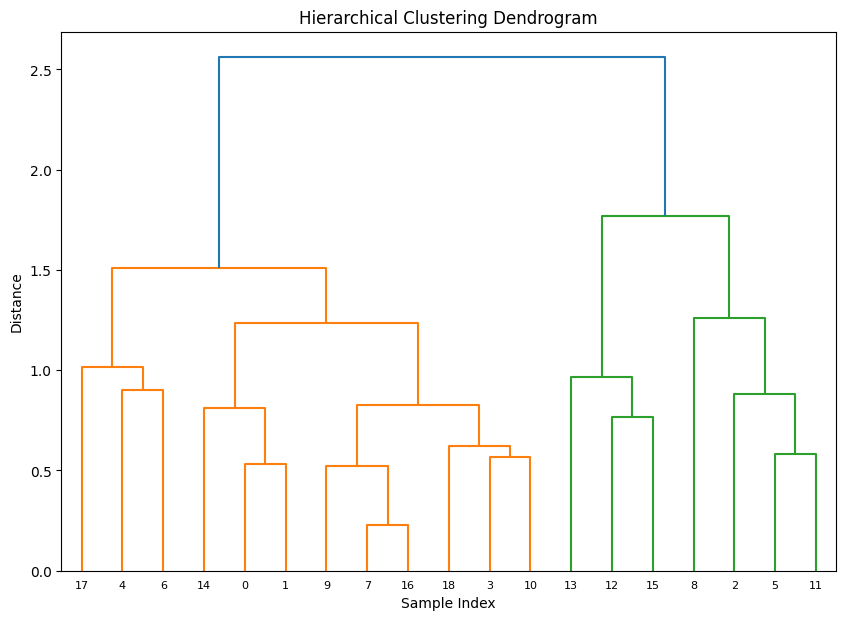

In [ ]:
# prompt: コサイン類似度で階層的クラスタリングを行い、デンドログラムを表示して下さい。

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Assuming 'embeddings' column exists in the DataFrame 'df'
if 'embeddings' in df.columns:
    # Convert embeddings to numpy array
    embeddings_array = np.array(df['embeddings'].tolist())

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_array)

    # Perform hierarchical clustering using cosine similarity
    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance
    linkage_matrix = linkage(distance_matrix, method='ward') # Use ward method for better results

    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=df.index.tolist(), orientation='top', leaf_font_size=8)  # Use df.index as labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
else:
    print("Error: 'embeddings' column not found in the DataFrame.")


In [8]:
# prompt: クラスタ数を指定すると、各クラスタに属するサンプルのサンプルインデクスとtext_culumnの内容を表示する

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

def show_cluster_members(linkage_matrix, df, n_clusters):
    # Perform clustering based on the specified number of clusters
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Print the sample indices and text_column content for each cluster
    for i in range(1, n_clusters + 1):
        cluster_members = df[cluster_labels == i]
        print(f"Cluster {i}:")
        for index, row in cluster_members.iterrows():
          print(f"  Index: {index}, Text: {row[text_column]}")

# Example usage (assuming linkage_matrix and df are already defined)
# Replace 'n_clusters' with your desired number of clusters
n_clusters = 6  # Example: 3 clusters
show_cluster_members(linkage_matrix, df, n_clusters)


Cluster 1:
  Index: 4, Text: 小学校低学年向けの勉強学習アプリを作ってみたい
  Index: 6, Text: カラオケが好きで、歌が上手くなりたいので、自分の歌の録音や、カラオケの点数の写真を読みとって、アドバイスをしてくれるようなソフトやアプリを作りたい
  Index: 17, Text: 豚の画像認識による病気の早期発見や、豚の体調の変化発見などのAIを作る
Cluster 2:
  Index: 0, Text: 財務諸表から企業の業績を予測し投資の意思決定をしてみたいです。
  Index: 1, Text: 食堂・売店のメニューを増やして欲しい→メニューが少ない理由の調査し、食堂・売店の売り上げ予測や店舗レイアウトの最適化を生成AI支援でおこない、メニュー増加によるコスト増、売り上げ増、利益の変化のシミュレーションをし、増加と利益につなげるものをプレゼンする。
  Index: 14, Text: 日向市特産品「へべす」に関するSNS上の情報を集めて、売れる新商品を開発したい
Cluster 3:
  Index: 3, Text: ワークショップの内容をみて，論文執筆や授業作成に活かせるのAI活用方法について知見を広げたい．
  Index: 7, Text: 生成AIの活用を経験しておきたい
  Index: 9, Text: AIを使って何か作品を作りたい
  Index: 10, Text: 就活の補助（自己分析を従来よりも正確にするものなど）
  Index: 16, Text: 就活／会議内容／大学の講義・課題などの様々な場面に関わらず、ユーザーの入れた情報（フォーマット形式）からカレンダー・メモ帳・画像（図）形式で重要順に表示する生成AIを作りたい。
  Index: 18, Text: 個人に寄り添い、おすすめの本や商品などを勧めるAIレコメンドに興味がある。文章を書くのにつまずいたときに好きそうな言葉や文章をおすすめしてくれるAIもあったらいいなと思う。
Cluster 4:
  Index: 12, Text: 宮崎市内で勉強ができる場所や利用状況を知れるアプリ（地図とつなげたい）
  Index: 13, Text: 宮崎の交通を改善できるもの（特にバス電車等）
  Index: 15, Text: 